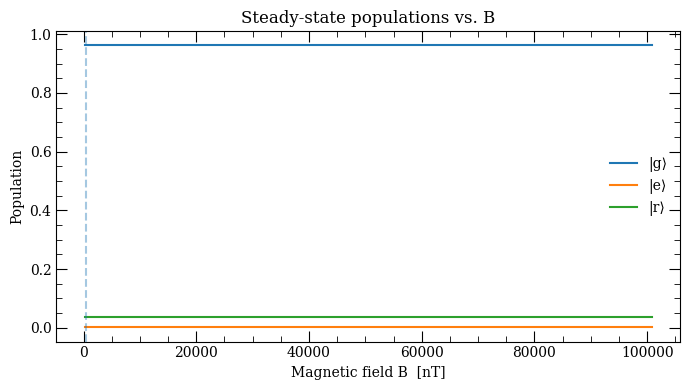

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import rydiqule as rq
from rydiqule.sensor_utils import (
    convert_dm_to_complex,      # turn Rydiqule’s real basis into complex
    get_rho_populations         # convenience extractor for populations
)
from rydiqule.solvers import solve_steady_state

# ---------- 1. core helper ---------------------------------------------------
def rydberg_density_matrix_from_B(
        B_T,
        mF_g=0, mF_e=0, mF_r=0,              # chosen Zeeman sub-levels
        gF_e=0.50, gF_r=0.50,                # Landé g-factors (Rb-87 F-specific)
        probe_rabi=2*np.pi*1e6,              # 1 MHz
        coupling_rabi=2*np.pi*5e6,           # 5 MHz
        gamma_ge=2*np.pi*6e6,                # |e⟩→|g⟩ 6 MHz
        gamma_er=2*np.pi*0.1e6,              # |r⟩→|e⟩ 0.1 MHz
        extra_dephasing=0                    # homogeneous broadening
    ):
    """
    Steady-state ρ for a 3-level ladder under a static B field.
    All rates in rad s⁻¹, B in Tesla.
    """
    muB_over_hbar = 1.399_624_60e6 * 2*np.pi   # (rad s⁻¹ T⁻¹)

    δe =  muB_over_hbar * gF_e * mF_e * B_T    # Zeeman shifts (rad s⁻¹)
    δr =  muB_over_hbar * gF_r * mF_r * B_T

    s = rq.Sensor(3)                           # |g>,|e>,|r|

    Γ = np.zeros((3, 3))
    Γ[1, 0] = gamma_ge
    Γ[2, 1] = gamma_er
    s.set_gamma_matrix(Γ)
    if extra_dephasing:
        # optional homogeneous decoherence – same for every pair
        s.add_decoherence_group([(i, j) for i in range(3) for j in range(3)],
                                extra_dephasing)

    # laser couplings ---------------------------------------------------------
    s.add_coupling(
        states=(0, 1),                         # probe |g>↔|e>
        rabi_frequency=probe_rabi,
        detuning=-δe                          # laser stays on resonance at B=0
    )
    s.add_coupling(
        states=(1, 2),                         # coupling |e>↔|r>
        rabi_frequency=coupling_rabi,
        detuning=-(δr - δe)                   # keeps two-photon resonance
    )

    sol = solve_steady_state(s)                                        # :contentReference[oaicite:0]{index=0}
    # convert from Rydiqule’s flattened real basis to a 3×3 complex matrix
    ρ_vec  = convert_dm_to_complex(sol.rho)                            # :contentReference[oaicite:1]{index=1}
    ρ      = ρ_vec.reshape(3, 3)
    return ρ



# ---------- 2. example usage --------------------------------------------------
if __name__ == "__main__":
    B_centre = 5e-7                # 500 nT in Tesla
    scan = np.linspace(B_centre-3e-7, B_centre+3e-7+1e-4, 151)   # ±300 nT
    pops = np.empty((scan.size, 3))

    for k, B in enumerate(scan):
        ρ = rydberg_density_matrix_from_B(B)
        pops[k] = np.real_if_close(np.diag(ρ))   # populations |g>,|e>,|r>

    # quick plot
    plt.figure(figsize=(7,4))
    plt.plot(scan*1e9, pops[:,0], label='|g⟩')
    plt.plot(scan*1e9, pops[:,1], label='|e⟩')
    plt.plot(scan*1e9, pops[:,2], label='|r⟩')
    plt.axvline(B_centre*1e9, ls='--', alpha=0.4)
    plt.xlabel("Magnetic field B  [nT]")
    plt.ylabel("Population")
    plt.title("Steady-state populations vs. B")
    plt.legend(frameon=False)
    plt.tight_layout()
    plt.show()


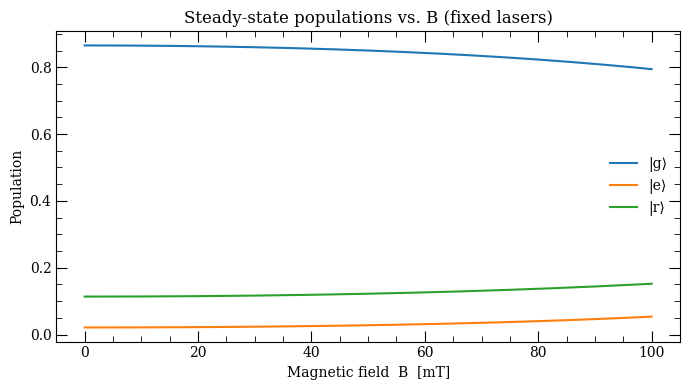

At 100.0 mT:   P(g) = 0.794, P(e) = 0.054, P(r) = 0.152
At 0 µT:   P(g) = 0.865, P(e) = 0.021, P(r) = 0.114


In [23]:
# rydberg_magnetometer_fixed_lasers.py
"""
Option A demo: lasers locked to zero-field resonance, atomic levels shift
with B.  Requires rydiqule ≥ v1.3.

Run as a script or copy the parts you need into a notebook.
"""
import numpy as np
import matplotlib.pyplot as plt
import rydiqule as rq
from rydiqule.solvers import solve_steady_state
from rydiqule.sensor_utils import convert_dm_to_complex

# ---------------------------------------------------------------------------
# CONSTANTS
# ---------------------------------------------------------------------------
MU_B_OVER_HBAR = 1.399_624_60e6 * 2 * np.pi   # rad s⁻¹ T⁻¹  (CODATA 2018)
# helper for a nice label later
def fmt_B(B): return f"{B*1e6:.0f} µT" if B < 1e-3 else f"{B*1e3:.1f} mT"

# ---------------------------------------------------------------------------
# CORE FUNCTION
# ---------------------------------------------------------------------------
def rydberg_dm_fixed_lasers(
        B_T,
        mF_g=0, mF_e=+1, mF_r=+1,
        gF_e=0.50, gF_r=0.50,
        probe_rabi=2*np.pi*1e5,      # 100 kHz
        coupling_rabi=2*np.pi*3e5,   # 300 kHz
        gamma_ge=2*np.pi*5e4,        # 50 kHz   (narrowed linewidth)
        gamma_er=2*np.pi*1e4,        # 10 kHz
        extra_dephasing=2*np.pi*1e4  # homogeneous decoherence 10 kHz
    ):
    """
    Steady-state density matrix ρ(B) for a 3-level ladder {|g>,|e>,|r>}.
    All rates in rad s⁻¹; B in Tesla.
    """
    # Zeeman shifts (rad s⁻¹)
    δe =  MU_B_OVER_HBAR * gF_e * mF_e * B_T
    δr =  MU_B_OVER_HBAR * gF_r * mF_r * B_T

    # -----------------------------------------------------------------------
    # Build the sensor
    s = rq.Sensor(3)                           # |0>=|g>, |1>=|e>, |2>=|r|
    Γ = np.zeros((3, 3))
    Γ[1, 0] = gamma_ge
    Γ[2, 1] = gamma_er
    s.set_gamma_matrix(Γ)

    # Optional homogeneous dephasing (same for every off-diag element)
    #if extra_dephasing:
    #    pairs = [(i, j) for i in range(3) for j in range(3) if i != j]
    #    s.add_decoherence_group(pairs, extra_dephasing)

    # -----------------------------------------------------------------------
    # Lasers remain tuned to ZERO-FIELD transition
    # → detunings equal the (negative) Zeeman shifts
    s.add_coupling(                       # probe |g> ↔ |e>
        states        = (0, 1),
        rabi_frequency= probe_rabi,
        detuning      = -δe
    )
    s.add_coupling(                       # coupling |e> ↔ |r>
        states        = (1, 2),
        rabi_frequency= coupling_rabi,
        detuning      = -(δr - δe)
    )

    sol = solve_steady_state(s)
    ρ = convert_dm_to_complex(sol.rho).reshape(3, 3)
    return ρ
# ---------------------------------------------------------------------------


# ---------------------------------------------------------------------------
# EXAMPLE SWEEP & PLOT
# ---------------------------------------------------------------------------
if __name__ == "__main__":
    # Scan 0 → 2 mT so that δe reaches ≈700 kHz (comparable to Rabi)
    B_scan = np.linspace(0.0, 100e-3, 300)   # Tesla
    pops = np.empty((B_scan.size, 3))

    for k, B in enumerate(B_scan):
        ρ = rydberg_dm_fixed_lasers(B)
        pops[k] = np.real_if_close(np.diag(ρ))

    # -----------------------------------------------------------------------
    plt.figure(figsize=(7, 4))
    plt.plot(B_scan*1e3, pops[:, 0], label='|g⟩')
    plt.plot(B_scan*1e3, pops[:, 1], label='|e⟩')
    plt.plot(B_scan*1e3, pops[:, 2], label='|r⟩')

    plt.xlabel("Magnetic field  B  [mT]")
    plt.ylabel("Population")
    plt.title("Steady-state populations vs. B (fixed lasers)")
    plt.legend(frameon=False)
    plt.tight_layout()
    plt.show()

    # quick sanity-check printout
    print(f"At {fmt_B(B_scan[-1])}:  ",
          ", ".join(f"P({lbl}) = {pop:.3f}"
                    for lbl, pop in zip(("g", "e", "r"), pops[-1])))
    # quick sanity-check printout
    print(f"At {fmt_B(B_scan[0])}:  ",
          ", ".join(f"P({lbl}) = {pop:.3f}"
                    for lbl, pop in zip(("g", "e", "r"), pops[0])))
